# Import Libraries

In [2]:
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
import keras
from keras import backend as K
from keras.models import Model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D,Conv1D,BatchNormalization

import tensorflow as tf
from tensorflow.python.framework import ops


#import argparse

import numpy as np


from tqdm import tqdm

Using TensorFlow backend.


# Set parameters and loading data

In [3]:
def blankBlackAndPreprocess(image):
    y = preprocess_input(image)
    x = y*((image>20)*1)
    return x

In [4]:
#train_dir=os.path.expanduser('/data/project/dti/For_William/pearcAbstract/preRotatedpreWarpRDBrainstemSlices/training')
train_dir=os.path.expanduser('/data/project/dti/For_William/pearcAbstract/sliceData/training')
validation_dir=os.path.expanduser('/data/project/dti/For_William/pearcAbstract/sliceData/validation')

batch_size=8
val_batch_size=4
base_lr=0.025
epochs=20


## create img generators

In [5]:
train_gen = image.ImageDataGenerator(
    width_shift_range=0, zoom_range=0, horizontal_flip=False,vertical_flip=False,preprocessing_function=preprocess_input)
train_iter = train_gen.flow_from_directory(train_dir,
    batch_size=batch_size,target_size=(197, 197))

val_gen = image.ImageDataGenerator(
    zoom_range=0,preprocessing_function=preprocess_input)
val_iter = val_gen.flow_from_directory(validation_dir,
    batch_size=val_batch_size,target_size=(197, 197))#,subset='validation')    #target_size=(197, 197))

NUM_CLASSES=2

Found 132 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


# creating a function to build the keras model

In [6]:
def build_model():
    """Function returning keras model instance.
    
    Model can be
     - Trained here
     - Loaded with load_model
     - Loaded from keras.applications
    """
    base_model=keras.applications.ResNet50(include_top = False,weights='imagenet',input_shape=(197,197,3))
    #base_model=keras.applications.InceptionResNetV2(include_top = False,weights='imagenet',input_shape=(197,197,3))
    #base_model=keras.applications.MobileNetV2(include_top = False,weights='imagenet',input_shape=(197,197,3))
    #base_model=keras.applications.VGG19(include_top = False,weights='imagenet',input_shape=(197,197,3))

    for layer in base_model.layers[:-5]: #259
        layer.trainable = False
        #print(layer.name)
    x=Flatten()(base_model.output)
    x=Dense(512, activation='relu')(x)
    x=BatchNormalization()(x)
    x=Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    
    model= Model(input = base_model.input, output=predictions)
    
    opt = keras.optimizers.Adam(lr=base_lr)

    model.compile(loss=keras.losses.categorical_crossentropy,    
                  optimizer=opt,
                  metrics=['accuracy', 'mae'])
    
    class_weight = {0: 1.,
                1: 1.,}
    
    model.fit_generator(train_iter,
                        steps_per_epoch=len(train_iter),
                        epochs=epochs,
                        verbose=2,
                        workers=24,
                        validation_data=val_iter,
                        validation_steps=3 * len(val_iter),class_weight=class_weight)
    
    return model
    

H, W = 197, 197 # Input shape, defined by the model (model.input_shape)

In [7]:
def build_guided_model():
    """Function returning modified model.
    
    Changes gradient function for all ReLu activations
    according to Guided Backpropagation.
    """
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                   tf.cast(op.inputs[0] > 0., dtype)

    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        new_model = build_model()
    return new_model


def guided_backprop(input_model, images, layer_name):
    """Guided Backpropagation method for visualizing input saliency."""
    input_imgs = input_model.input
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(layer_output, input_imgs)[0]
    backprop_fn = K.function([input_imgs, K.learning_phase()], [grads])
    grads_val = backprop_fn([images, 0])[0]
    return grads_val

In [8]:
def grad_cam(input_model, image, cls, layer_name):
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.input], [conv_output, grads])

    output, grads_val = gradient_function([image])
    #print("output",output.shape)
    #print("grads_val",grads_val.shape)

    #output, grads_val = output[0, :], grads_val[0, :, :, :]
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    #print("grads_val",grads_val.shape)
    weights = np.mean(grads_val, axis=(0,1))
    #print("weights",weights.shape)
    #print("outputs",output.shape)

    cam = np.dot(output, weights)

    # Process CAM
    cam = cv2.resize(cam, (W, H), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

def grad_cam_batch(input_model, images, classes, layer_name):
    """GradCAM method for visualizing input saliency.
    Same as grad_cam but processes multiple images in one run."""
    loss = tf.gather_nd(input_model.output, np.dstack([range(images.shape[0]), classes])[0])
    layer_output = input_model.get_layer(layer_name).output
    grads = K.gradients(loss, layer_output)[0]
    gradient_fn = K.function([input_model.input, K.learning_phase()], [layer_output, grads])

    conv_output, grads_val = gradient_fn([images, 0])    
    weights = np.mean(grads_val, axis=(1, 2))
    cams = np.einsum('ijkl,il->ijk', conv_output, weights)
    
    # Process CAMs
    new_cams = np.empty((images.shape[0], H, W))
    for i in range(new_cams.shape[0]):
        cam_i = cams[i] - cams[i].mean()
        cam_i = (cam_i + 1e-10) / (np.linalg.norm(cam_i, 2) + 1e-10)
        new_cams[i] = cv2.resize(cam_i, (W, H), cv2.INTER_LINEAR)
        new_cams[i] = np.maximum(new_cams[i], 0)
        new_cams[i] = new_cams[i] / new_cams[i].max()
    
    return new_cams

In [9]:
def compute_saliency(model, guided_model, img_path, layer_name='block5_conv3', cls=-1, visualize=True, save=True):
    """Compute saliency using all three approaches.
        -layer_name: layer to compute gradients;
        -cls: class number to localize (-1 for most probable class).
    """
    base=os.path.split(f)
    filenameNoExt = os.path.splitext(base[1])[0]
    filenameNewExt = filenameNoExt + "_gradcam.jpg"
    print(filenameNewExt)
    preprocessed_input = load_image(img_path)

    predictions = model.predict(preprocessed_input)
    top_n = 2
    #top = decode_predictions(predictions, top=top_n)[0]
    top = predictions
    classes = np.argsort(predictions[0])[-top_n:][::-1]
    print('Model prediction:')
    #for c, p in zip(classes, top):
    for c, p in zip(classes, top):
        print('\t{:15f}\t({})\twith probability {:.3f}'.format(p[0], c, p[1]))
        #print('\t{:15s}\t({})\twith probability {:.3f}'.format(p[1], c, p[2]))

    if cls == -1:
        cls = np.argmax(predictions)
    #class_name = decode_predictions(np.eye(1, 1000, cls))[0][0][1]
    print("Explanation for '{}'".format(cls))
    
    gradcam = grad_cam(model, preprocessed_input, cls, layer_name)
    gb = guided_backprop(guided_model, preprocessed_input, layer_name)
    guided_gradcam = gb * gradcam[..., np.newaxis]

    if save:
        jetcam = cv2.applyColorMap(np.uint8(255 * gradcam), cv2.COLORMAP_JET)
        jetcam = (np.float32(jetcam)) / 2
        cv2.imwrite(filenameNewExt, np.uint8(jetcam))
        cv2.imwrite('guided_backprop.jpg', deprocess_image(gb[0]))
        cv2.imwrite('guided_gradcam.jpg', deprocess_image(guided_gradcam[0]))
    
    if visualize:
        #fig, aa= plt.subplots()
        plt.figure(figsize=(15, 10))
        #ax = plt.subplot(131)
        plt.title('GradCAM')
        plt.axis('off')
        #plt.colorbar(grad_cam,ax=0)
        plt.imshow(load_image(img_path, preprocess=False))
        plt.imshow(gradcam, cmap='jet', alpha=0.5)
        plt.colorbar()
        #fig.colorbar(im, ax=ax)


        '''plt.subplot(132)
        plt.title('Guided Backprop')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(gb[0]), -1))
        
        plt.subplot(133)
        plt.title('Guided GradCAM')
        plt.axis('off')
        plt.imshow(np.flip(deprocess_image(guided_gradcam[0]), -1))'''
        plt.show()
        
    return gradcam, gb, guided_gradcam

In [62]:
model = build_model()
guided_model = build_guided_model()

/home/wsmonroe/.conda/envs/distributedLearning/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/wsmonroe/.conda/envs/distributedLearning/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/20
 - 33s - loss: 2.1297 - acc: 0.5759 - mean_absolute_error: 0.4161 - val_loss: 1.9844 - val_acc: 0.6944 - val_mean_absolute_error: 0.3046
Epoch 2/20
 - 1s - loss: 1.3671 - acc: 0.7285 - mean_absolute_error: 0.2701 - val_loss: 1.9752 - val_acc: 0.6667 - val_mean_absolute_error: 0.3392
Epoch 3/20
 - 1s - loss: 0.6201 - acc: 0.8912 - mean_absolute_error: 0.1174 - val_loss: 1.0201 - val_acc: 0.5278 - val_mean_absolute_error: 0.4545
Epoch 4/20
 - 1s - loss: 0.8817 - acc: 0.8640 - mean_absolute_error: 0.1425 - val_loss: 1.3188 - val_acc: 0.5000 - val_mean_absolute_error: 0.4856
Epoch 5/20
 - 1s - loss: 1.0670 - acc: 0.8534 - mean_absolute_error: 0.1591 - val_loss: 2.3737 - val_acc: 0.6667 - val_mean_absolute_error: 0.3324
Epoch 6/20
 - 1s - loss: 0.9322 - acc: 0.8699 - mean_absolute_error: 0.1333 - val_loss: 4.8126 - val_acc: 0.6667 - val_mean_absolute_error: 0.3333
Epoch 7/20
 - 1s - loss: 1.5345 - acc: 0.8425 - mean_absolute_error: 0.1572 - val_loss: 5.3727 - val_acc: 0.6667 - va

In [63]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [64]:
guided_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 197, 197, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 203, 203, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 99, 99, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 99, 99, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
def load_image(path, preprocess=True):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        x = image.img_to_array(x)
        x = np.expand_dims(x, axis=0)
        #x = blankBlackAndPreprocess(x)
        x = preprocess_input(x)
    return x


def deprocess_image(x):
    """Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    """
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_dim_ordering() == 'th':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def normalize(x):
    """Utility function to normalize a tensor by its L2 norm"""
    return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)

In [11]:
#gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, 'keras-gradcam/cat_dog.png', layer_name='bn5c_branch2c', 
#                                               cls=-1, visualize=True, save=True)
#gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, 'keras-gradcam/cat_dog.png', layer_name='dense_9',
#                                               cls=282, visualize=True, save=False)

In [12]:
import glob
ff = glob.glob('/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/*/*')

In [13]:
import random
random.shuffle(ff)
ff

['/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/pd/3123.RD.grid15rotat.3mmWARP.brainstem.png',
 '/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/hc/3169.RD.grid15rotat.3mmWARP.brainstem.jpg',
 '/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/pd/3375.RD.grid15rotat.3mmWARP.brainstem.png',
 '/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/pd/3120.RD.grid15rotat.3mmWARP.brainstem.jpg',
 '/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/pd/3376.RD.grid15rotat.3mmWARP.brainstem.jpg',
 '/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/hc/3563.RD.grid15rotat.3mmWARP.brainstem.jpg',
 '/data/project/dti/For_William/pearcAbstract/postRotatedpostWarpRDBrainstemSlices/training/hc/3104.RD.grid15rotat.3mmWARP.brainstem.png',
 '/data/project/dti/For_Wil

3551.RD.grid15rotat.3mmWARP.brainstem_gradcam.jpg
Model prediction:
	       0.000000	(1)	with probability 1.000
Explanation for '1'


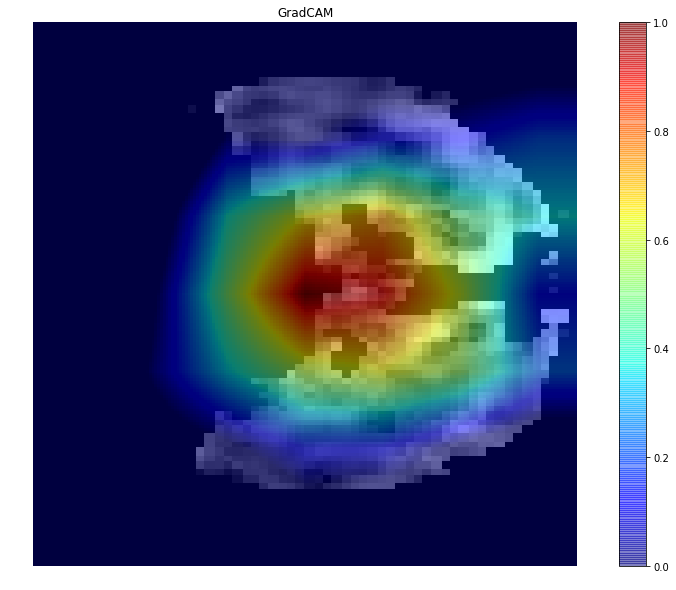

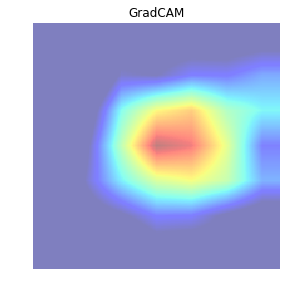

3373.RD.grid15rotat.3mmWARP.brainstem_gradcam.jpg
Model prediction:
	       0.000004	(1)	with probability 1.000
Explanation for '1'


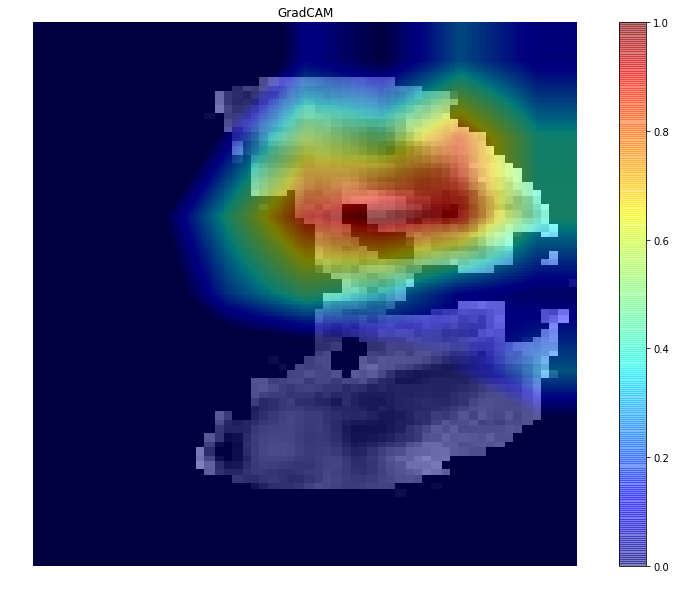

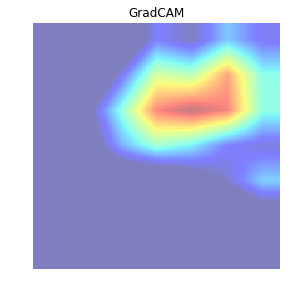

3377.RD.grid15rotat.3mmWARP.brainstem_gradcam.jpg
Model prediction:
	       0.000000	(1)	with probability 1.000
Explanation for '1'


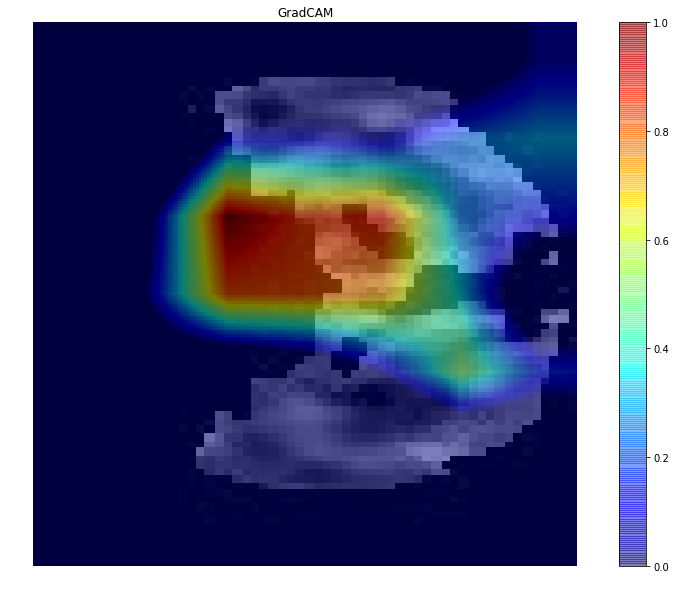

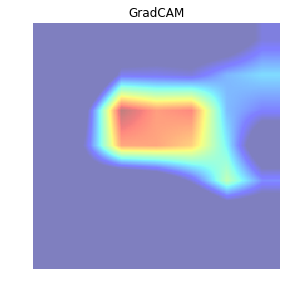

3383.RD.grid15rotat.3mmWARP.brainstem_gradcam.jpg
Model prediction:
	       0.000003	(1)	with probability 1.000
Explanation for '1'


In [ ]:
for f in ff:
    gradcam, gb, guided_gradcam = compute_saliency(model, guided_model, f, layer_name='bn5c_branch2c', 
                                               cls=-1, visualize=True, save=True)
    plt.figure(figsize=(15, 10))
    plt.subplot(131)
    plt.title('GradCAM')
    plt.axis('off')
    #plt.imshow(load_image(img_path, preprocess=False))
    plt.imshow(gradcam, cmap='jet', alpha=0.5)
    plt.show()

In [ ]:
np.mean(gradcam)

In [14]:
IIT = load_image('IIT2mean.FA.Brainstem.jpg')

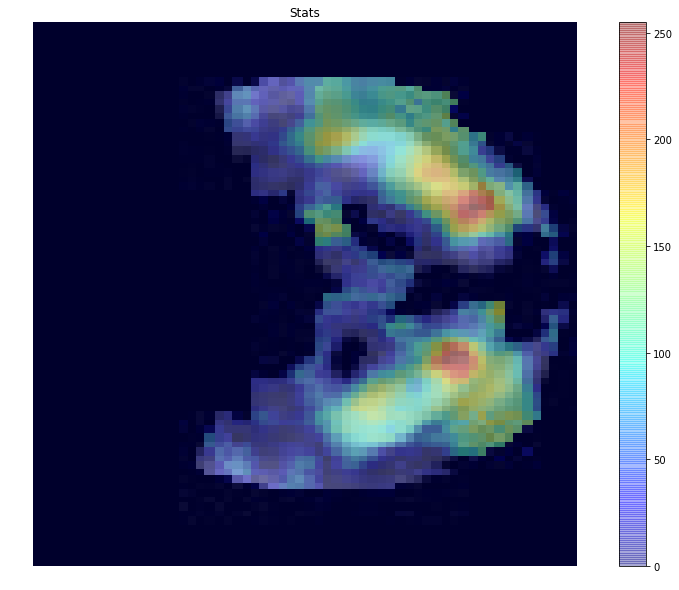

In [15]:
#fig, aa= plt.subplots()
plt.figure(figsize=(15, 10))
#ax = plt.subplot(131)
plt.title('Stats')
plt.axis('off')
#plt.colorbar(grad_cam,ax=0)
plt.imshow(load_image('IIT2mean.FA.Brainstem.jpg', preprocess=False))
rd=load_image('RDmap.jpg', preprocess=False)
plt.imshow(np.array(rd)[:,:,0], cmap='jet',alpha=0.35)
plt.colorbar()

In [54]:
gg = glob.glob('/data/project/dti/For_William/pearcAbstract/outVisCAMHihO/resnet50/0/*.jpg')
aggregate=np.zeros_like(IIT)
for g in gg:
    sal = load_image(g)
    sal=sal-np.min(sal)
    sal=sal/np.max(sal)
    print(np.max(sal))
    print(np.min(sal))
    aggregate = (sal>0.5)*1 + aggregate


1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0
1.0
0.0


(1, 197, 197, 3)


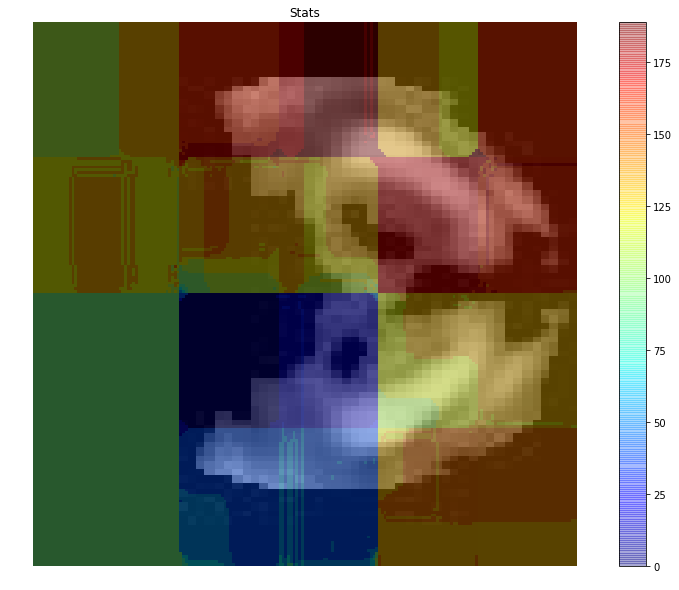

In [55]:
print(IIT.shape)
#print(max(aggregate))
plt.figure(figsize=(15, 10))
#ax = plt.subplot(131)
plt.title('Stats')
plt.axis('off')
#plt.colorbar(grad_cam,ax=0)
plt.imshow(load_image('IIT2mean.FA.Brainstem.jpg', preprocess=False))
#rd=load_image('RDmap.jpg', preprocess=False)
plt.imshow(aggregate[0,:,:,0], cmap='jet',alpha=0.35)
plt.colorbar()